In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
from sklearn.model_selection import train_test_split

from convexmtl_torch.model.ConvexMTLPytorchModel import ConvexMTLPytorchRegressor
from convexmtl_torch.model.GraphLaplacianMTLPytorchModel import GraphLaplacianMTLPytorchRegressor

from convexmtl_torch.model.utils import NeuralNetwork

from sklearn.model_selection import GridSearchCV

from convexmtl_torch.data.MTLSyntheticDataset import MTLFunctionsRegression

import torch
from torch.nn import MSELoss
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from pytorch_lightning import Trainer

from icecream import ic

import matplotlib.pyplot as plt
import matplotlib.cm as cm

from copy import copy

from utils import train_gs

import random


In [2]:
max_epochs=50
log_every_n_steps=10
problem = 'common'

In [3]:
seed = 1

torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

In [4]:
mtlds = MTLFunctionsRegression(n_samples_per_task=100)

X, y = mtlds.X, mtlds.y

if y.ndim < 2:
    y = y[:, None]

Init Synth
TASK FUNCTIONS


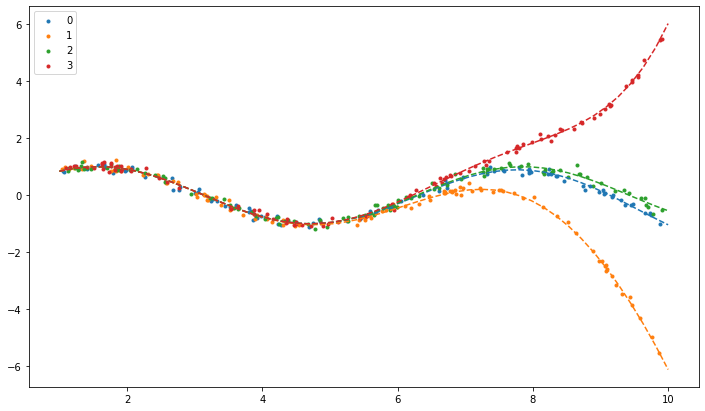

In [5]:
mtlds.plot_data_functions(X, y)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

X_test_numpy = copy(X_test)

In [7]:
X_train.shape

(268, 2)

## ConvexMTL Torch

In [8]:
model = ConvexMTLPytorchRegressor(lamb=0.5, lambda_trainable=False, train_mode='lightning', epochs=1000, batch_size=32, val_size=0, n_hidden_common=16, early_stopping=True, patience=50)
model

ConvexMTLPytorchRegressor(batch_size=32, epochs=1000, patience=50,
                          train_mode='lightning', val_size=0)

In [9]:
wd_l = [10**(k) for k in range(-2, 1)]
lamblr_l = [10**(k) for k in range(-2, -1)]

params = {
    'weight_decay' : wd_l,
    # 'lambda_lr' : lamblr_l,
}
params

{'weight_decay': [0.01, 0.1, 1]}

In [10]:
# best = train_gs(model, params, X_train, y_train, model_name='convexmtlNN', problem_name=problem, scoring='neg_mean_squared_error', retrain=False)
best = model

In [11]:
best.fit(X_train, y_train)

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/carlos.ruizp/miniconda3/envs/rkm/lib/python3.9/site-packages/pytorch_lightning/trainer/setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=2)`.
  rank_zero_warn(
/home/carlos.ruizp/miniconda3/envs/rkm/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:108: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn(

  | Name           | Type          | Params
-------------------------------------------------
0 | common_module_ | NeuralNetwork | 2.2 K 
-------------------------------------------------
2.2 K     Trainable params
1         Non-trainable params
2.2 K     Total params
0.009     Total estimated model params size (MB)
/home/carlos.ruizp/miniconda3/

Training: 0it [00:00, ?it/s]

In [12]:
pred = best.predict(X_test)

In [13]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

mean_squared_error(pred, y_test)

0.021586584853789274

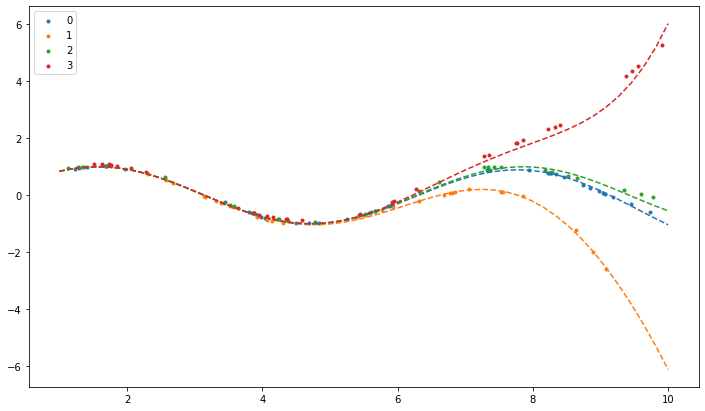

In [14]:
mtlds.plot_data_functions(X_test, pred)

In [15]:
from convexmtl_torch.model.ConvexMTLPytorchModel import ConvexMTLPytorchRegressor

pred = best.predict_common(X_test)

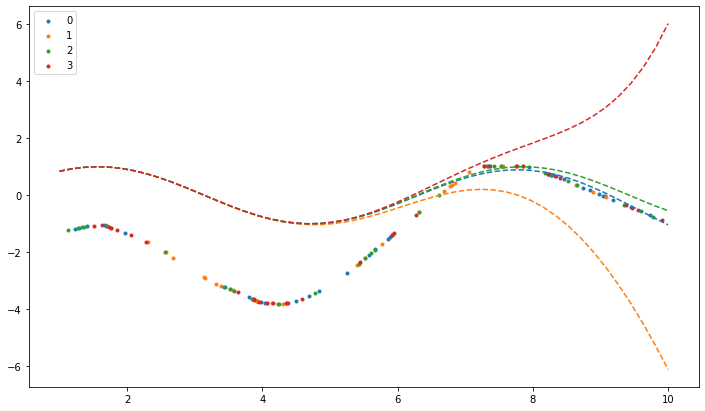

In [16]:
mtlds.plot_data_functions(X_test, pred)

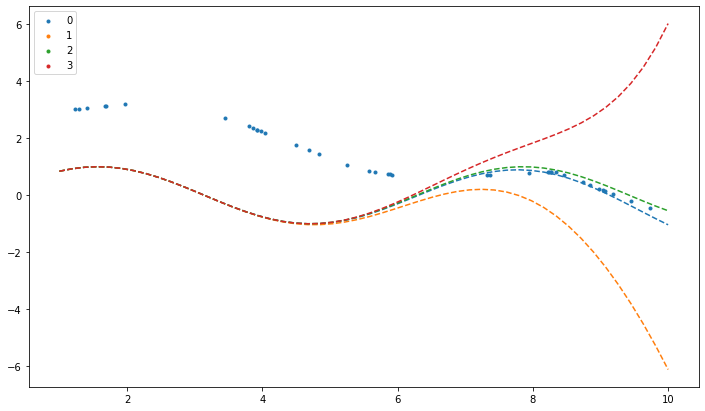

In [17]:
task = 0

t_idx = X_test[:, -1] == task
pred = best.predict_task(X_test[t_idx, :], task=task)
mtlds.plot_data_functions(X_test[t_idx], pred)

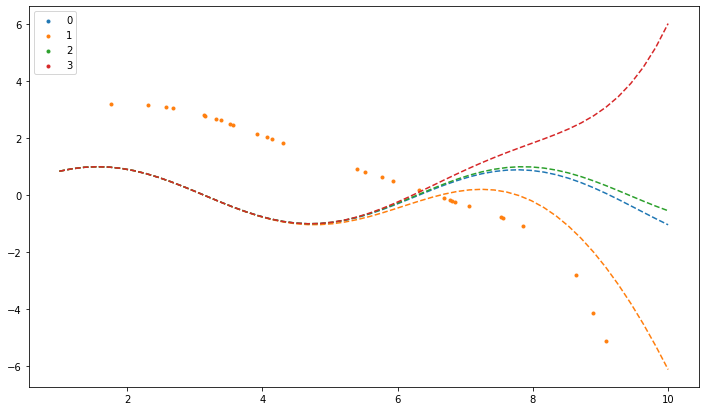

In [18]:
task = 1

t_idx = X_test[:, -1] == task
pred = best.predict_task(X_test[t_idx, :], task=task)
mtlds.plot_data_functions(X_test[t_idx], pred)

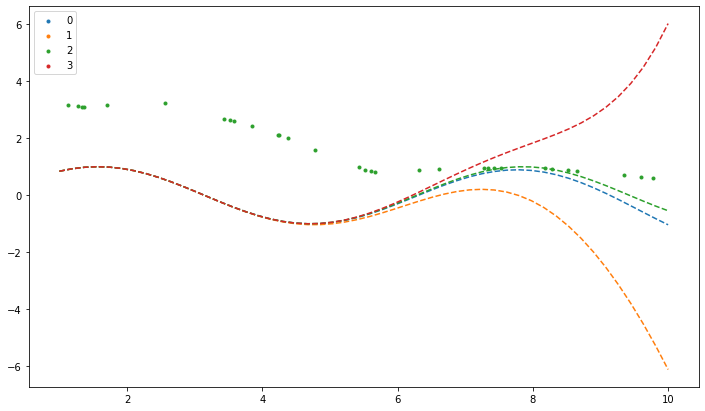

In [19]:
task = 2

t_idx = X_test[:, -1] == task
pred = best.predict_task(X_test[t_idx, :], task=task)
mtlds.plot_data_functions(X_test[t_idx], pred)

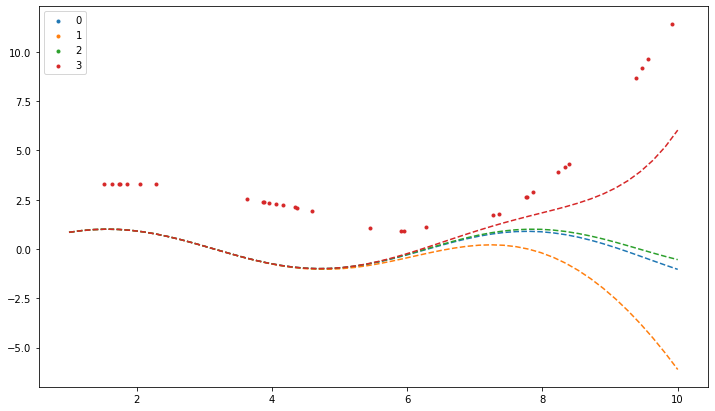

In [20]:
task = 3

t_idx = X_test[:, -1] == task
pred = best.predict_task(X_test[t_idx, :], task=3)
mtlds.plot_data_functions(X_test[t_idx], pred)

In [21]:
best.model.get_lamb()

array([0.50000006], dtype=float32)

## Tensorboard

In [22]:
%reload_ext tensorboard
%tensorboard --logdir=lightning_logs/